In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.model_selection import GridSearchCV, KFold 

## Data-generating process

In [2]:
theta_0 = 1   # true ATE
mean = np.array([1, 0])
cov = np.array([[1, -0.2], [-0.2, 0.5]])
beta = np.array([1, 2, -1])
F = lambda z: 1 / (1 + np.exp(-z))   # standard logistic function

# Propensity score
m_0 = lambda x: F(x @ beta)

# Outcome regression function
def g_0(d, x):
    if x.ndim == 1:
        x = x.reshape(1,-1)
    return d*x[:,0] + x[:,1] - x[:,2]

In [3]:
# Generate a dataset of size N in a vectorized fashion
def get_data(N):
    x_12 = np.random.multivariate_normal(mean=mean, cov=cov, size=N)
    x_3 = np.random.uniform(size=N)
    x_data = np.concatenate((x_12, x_3.reshape(N,1)), axis=1)

    xi = np.random.logistic(size=N)
    d_data = (x_data @ beta + xi >= 0)
        
    u = np.random.normal(scale=x_3)
    y_data = g_0(d_data, x_data) + u 

    return y_data, d_data, x_data

## MC simulation of infeasible method-of-moments estimator

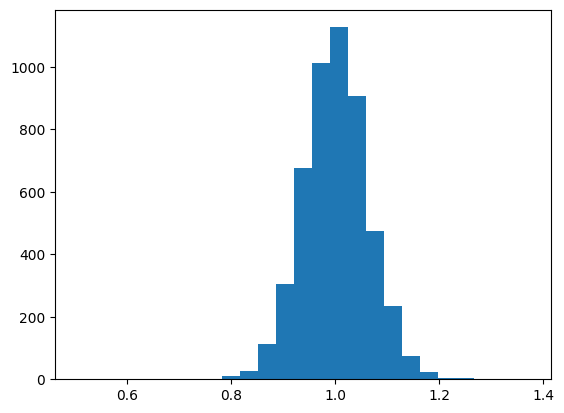

CPU times: total: 3.47 s
Wall time: 3.52 s


In [4]:
%%time
n_MC = 5000
N = 1000
estimates_list = []

for j in range(n_MC):
    y_data, d_data, x_data = get_data(N)
    estimate = np.mean(g_0(1, x_data) - g_0(0, x_data) + d_data*(y_data-g_0(1, x_data))/m_0(x_data)
                       - (1-d_data)*(y_data-g_0(0, x_data))/(1-m_0(x_data)))
    estimates_list.append(estimate)
    
plt.hist(estimates_list, bins=25)
plt.show()

In [5]:
np.mean(estimates_list)

1.0008811587943873

## Fix one dataset for DML investigation

In [6]:
#np.random.seed(seed=123)
N = 1000
y_data, d_data, x_data = get_data(N)
print(f'Percentage of treated units: {np.mean(d_data)}')

Percentage of treated units: 0.586


In [7]:
np.mean(np.abs(g_0(d_data, x_data) - y_data))

0.40209560830598723

In [8]:
N_train = int(0.8 * N)
y_train, d_train, x_train = y_data[:N_train], d_data[:N_train], x_data[:N_train]
y_eval, d_eval, x_eval = y_data[N_train:], d_data[N_train:], x_data[N_train:]

How well does xgboost perform?

For $g_0(1,\cdot)=E[Y|D=1,X]$:

In [9]:
model_1 = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model_1, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid_search.fit(x_data[d_data==1], y_data[d_data==1])

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
#test_predictions = best_model.predict(X_test)

# You can also access other information, such as the best score
print("Best Score (neg_mean_squared_error):", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 2, 'n_estimators': 30}
Best Score (neg_mean_squared_error): -0.38155146411847934


In [11]:
model_1 = xgb.XGBRegressor(n_estimators=30, max_depth=2)
model_1.fit(X=x_train[d_train==1], y=y_train[d_train==1])
print(f'Training error: {np.mean(np.abs(model_1.predict(x_train) - g_0(1, x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_1.predict(x_eval) - g_0(1, x_eval)))}')

Training error: 0.1975437121094898
Evaluation error: 0.24601998351384202


For $g_0(0,\cdot)=E[Y|D=0,X]$:

In [10]:
model_0 = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model_0, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid_search.fit(x_data[d_data==0], y_data[d_data==0])

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
#test_predictions = best_model.predict(X_test)

# You can also access other information, such as the best score
print("Best Score (neg_mean_squared_error):", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 2, 'n_estimators': 10}
Best Score (neg_mean_squared_error): -0.4710312644976419


In [12]:
model_0 = xgb.XGBRegressor(n_estimators=10, max_depth=2)
model_0.fit(X=x_train[d_train==0], y=y_train[d_train==0])
print(f'Training error: {np.mean(np.abs(model_0.predict(x_train) - g_0(0, x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_0.predict(x_eval) - g_0(0, x_eval)))}')

Training error: 0.16683957571952596
Evaluation error: 0.18885368916250603


For $m_0=E[D|X]$:

In [13]:
model_m = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model_m, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model to the training data
grid_search.fit(x_data, d_data)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
#test_predictions = best_model.predict(X_test)

# You can also access other information, such as the best score
print("Best Score (neg_mean_squared_error):", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 2, 'n_estimators': 15}
Best Score (neg_mean_squared_error): -0.1805219203233719


In [14]:
model_m = xgb.XGBRegressor(n_estimators=15, max_depth=2)
model_m.fit(X=x_train, y=d_train)
print(f'Training error: {np.mean(np.abs(model_m.predict(x_train) - m_0(x_train)))}')
print(f'Evaluation error: {np.mean(np.abs(model_m.predict(x_eval) - m_0(x_eval)))}')

Training error: 0.07277646602258346
Evaluation error: 0.0689038133493082


## DML algorithm

In [37]:
# Neyman orthogonal score
def psi_ate(h_0, h_1, h_2, y, d, x, theta):
    return h_1(x) - h_0(x) + d*(y-h_1(x))/h_2(x) - (1-d)*(y-h_0(x))/(1-h_2(x)) - theta

In [15]:
def dml_ate(K, y_data, d_data, x_data):
    # Generate random partition of data for cross-fitting
    indices = np.arange(N)
    kf = KFold(n_splits=K, shuffle=True)#, random_state=42)

    # Compute respective ML estimators and thereupon auxiliary estimators
    theta_0_check = []
    for (train_indices, eval_indices) in kf.split(x_data):
        y_train, d_train, x_train = y_data[train_indices], d_data[train_indices], x_data[train_indices]
        y_eval, d_eval, x_eval = y_data[eval_indices], d_data[eval_indices], x_data[eval_indices]

        # Estimate outcome regression functions g_0(d)
        g_0_hat = []
        hyperparam = [[10, 2], [30, 2]]
        for d in [0,1]:
            model = xgb.XGBRegressor(n_estimators=hyperparam[d][0], max_depth=hyperparam[d][1])
            model.fit(X=x_train[d_train==d], y=y_train[d_train==d])
            g_0_hat.append(model.predict(x_eval))

        # Estimate propensity score m_0
        model = xgb.XGBRegressor(n_estimators=15, max_depth=2)
        model.fit(X=x_train, y=d_train)
        m_0_hat = model.predict(x_eval)
            
        # Compute auxiliary estimator
        theta_0_check.append(np.mean(g_0_hat[1] - g_0_hat[0] + d_eval*(y_eval-g_0_hat[1])/m_0_hat
                                     - (1-d_eval)*(y_eval-g_0_hat[0])/(1-m_0_hat)))

    # Compute final estimator
    theta_0_hat = np.mean(theta_0_check)

    return theta_0_hat

In [32]:
%%time
K = 5
dml_ate(K, y_data, d_data, x_data)

CPU times: total: 984 ms
Wall time: 297 ms


0.9471989353452092

## MC simulation of DML

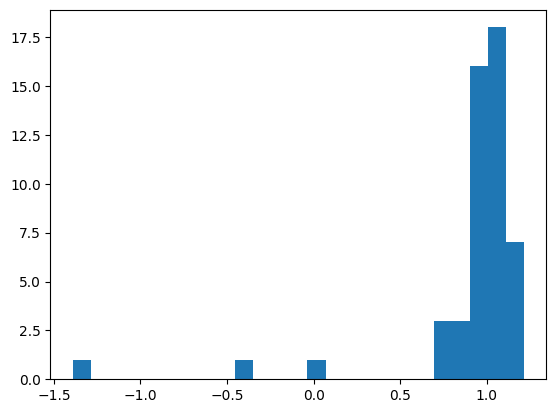

CPU times: total: 53.1 s
Wall time: 15.4 s


In [34]:
%%time
N = 1000
n_MC = 50
K = 5
estimates_list = []

for j in range(n_MC):
    y_data, d_data, x_data = get_data(N)
    estimate = dml_ate(K, y_data, d_data, x_data)
    estimates_list.append(estimate)
    
plt.hist(estimates_list, bins = 25)
plt.show()

In [385]:
estimates_list.sort()
np.mean(estimates_list[100:4900])

0.5131633955414944

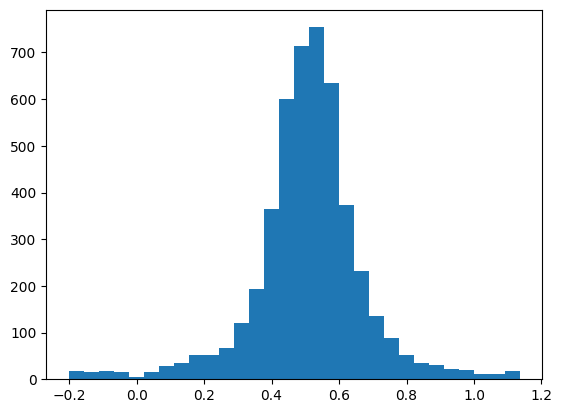

In [386]:
plt.hist(estimates_list[125:4850], bins=30)
plt.show()